In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
# %matplotlib inline

### get images

In [5]:
img_folder = 'D:\\ACA\\fyp\\codes\\video_image_crop_traffic_light\\all_selected_imgs'
# img_folder = 'D:\\ACA\\fyp\codes\\bbox_concatenate\\test_set_1'
img_list = [file for file in os.listdir(img_folder) if file.endswith('jpg')]
wide_img_list = [img for img in img_list if 'wide' in img]
narrow_img_list = [img for img in img_list if 'narrow' in img]

wide_img_list.sort()
narrow_img_list.sort()


### get camera details

In [4]:
narrow_cam_details_file = 'narrow_cam_details.txt'

camera_matrix_raw = 15
distortion_raw = 20
rectification_raw = 23
projection_raw = 27

w,h = 1920,1080

camera_mtx_narrow = np.loadtxt(narrow_cam_details_file, dtype=np.float32, skiprows=camera_matrix_raw-1, max_rows=3, delimiter=' ')
dist_coff_narrow = np.loadtxt(narrow_cam_details_file, dtype=np.float32, skiprows=distortion_raw-1,max_rows=1, delimiter=' ')
newcameramtx_narrow, roi = cv2.getOptimalNewCameraMatrix(camera_mtx_narrow, dist_coff_narrow, (w,h), 1, (w,h))

### calculate homography matrix

In [3]:
def calc_homograpy(narrow_img, wide_img, MIN_MATCH_COUNT):

    # Initiate SIFT detector
    sift = cv2.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(narrow_img,None)
    kp2, des2 = sift.detectAndCompute(wide_img,None)
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)


    #######################
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        # print(M)
        # matchesMask = mask.ravel().tolist()

        # draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                #    singlePointColor = None,
                #    matchesMask = matchesMask, # draw only inliers
                #    flags = 2)
        # img3 = cv2.drawMatches(narrow_img,kp1,wide_img,kp2,good,None,**draw_params)
        # plt.imshow(img3, 'gray'),plt.show()

    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None


    return M

### get homography for each image

In [6]:
homography_mtx_array = []

i=0
for narrow_img_name, wide_img_name in zip(narrow_img_list,wide_img_list):
    narrow_img = cv2.imread(os.path.join(img_folder, narrow_img_name))
    wide_img = cv2.imread(os.path.join(img_folder, wide_img_name))
    narrow_img_undist = cv2.undistort(narrow_img, camera_mtx_narrow, dist_coff_narrow, None, newcameramtx_narrow)
    homography_mtx = calc_homograpy(narrow_img_undist, wide_img, MIN_MATCH_COUNT=10)
    homography_mtx_array.append(homography_mtx)
    i+=1
    print(i,end =" "),

homography_mtx_array = np.array(homography_mtx_array)




(153, 1, 2) [[[  54.871098 1030.8416  ]]

 [[ 122.877556  751.88745 ]]

 [[ 147.1318    223.07066 ]]

 [[ 147.1318    223.07066 ]]

 [[ 175.47818   273.65204 ]]

 [[ 222.38539   458.6235  ]]

 [[ 227.29305   748.8338  ]]

 [[ 229.92772   255.34355 ]]

 [[ 254.73303   774.64923 ]]

 [[ 263.10562   919.1894  ]]

 [[ 264.667     461.3077  ]]

 [[ 266.94263   216.918   ]]

 [[ 289.45627   422.615   ]]

 [[ 290.76483   812.7841  ]]

 [[ 296.78824    84.92768 ]]

 [[ 302.53775   830.25714 ]]

 [[ 302.87253   368.70255 ]]

 [[ 327.04245   346.25717 ]]

 [[ 332.2867    197.63472 ]]

 [[ 335.87497   891.3744  ]]

 [[ 339.76675   843.9871  ]]

 [[ 340.4034    674.5507  ]]

 [[ 359.3313    856.5776  ]]

 [[ 369.01706   790.7902  ]]

 [[ 391.19205   759.79065 ]]

 [[ 393.05106   924.50256 ]]

 [[ 399.1969    881.4173  ]]

 [[ 400.2725    687.5892  ]]

 [[ 429.20425   732.5959  ]]

 [[ 429.20425   732.5959  ]]

 [[ 433.4499    194.48569 ]]

 [[ 447.134     812.83234 ]]

 [[ 454.17706   680.57983 ]]

In [52]:
np.save('homography_array_2.npy', homography_mtx_array)

### get average homography matrix

In [6]:
array_1 = np.load('homography_array_1.npy')
array_2 = np.load('homography_array_2.npy')
homography_mtx_array = np.concatenate((array_1,array_2),axis=0)

In [7]:
print(homography_mtx_array.shape)

(600, 3, 3)


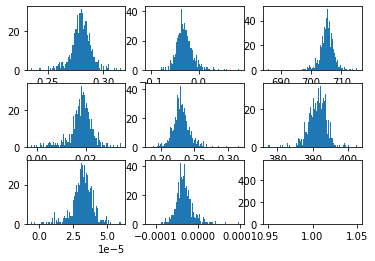

In [8]:
i = 1
for x in range(3):
    for y in range(3):
        val_array = np.squeeze(homography_mtx_array[:,x,y])
        plt.subplot(3,3,i)
        plt.hist(val_array,bins=100)
        i +=1
plt.show()

In [9]:
## reject outliers considering median (median is more robust to outliers than mean)
## from https://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

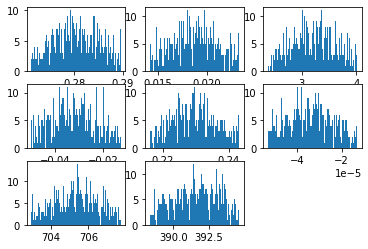

[[ 2.80611140e-01 -3.19748320e-02  7.05360622e+02]
 [ 1.87621200e-02  2.29448989e-01  3.91547918e+02]
 [ 3.22652241e-05 -3.42103019e-05  1.00000000e+00]]
[[4.58119808e-03 9.27929314e-03 1.17285399e+00]
 [2.30040087e-03 6.67342972e-03 1.59435505e+00]
 [4.03450580e-06 9.91449842e-06 2.79400001e-17]]


In [13]:
homography_mtx = np.zeros((3,3))
std_matrix = np.zeros((3,3))
i = 1

for x in range (3):
    for y in range (3):
        val_array = np.squeeze(homography_mtx_array[:,y,x])
        val_array = reject_outliers(data=val_array,m=2)
        value = np.mean(val_array)
        homography_mtx[y,x] = value
        std_matrix[y,x] = np.std(val_array)
        ###
        if not (i==9):
            plt.subplot(3,3,i)
            plt.hist(val_array,bins=100)
            i+=1

plt.show()
print(homography_mtx)

In [22]:
print("before remove outliers")
print(np.std(homography_mtx_array,axis=0))

print("\nafter remove outliers")
print(std_matrix)

before remove outliers
[[9.07379300e-03 1.82301021e-02 2.56725378e+00]
 [4.77517194e-03 1.35895486e-02 2.68025537e+00]
 [8.00981761e-06 2.00732583e-05 2.79400001e-17]]

after remove outliers
[[4.58119808e-03 9.27929314e-03 1.17285399e+00]
 [2.30040087e-03 6.67342972e-03 1.59435505e+00]
 [4.03450580e-06 9.91449842e-06 2.79400001e-17]]


### test on image

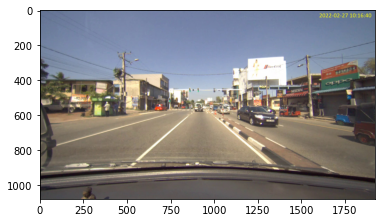

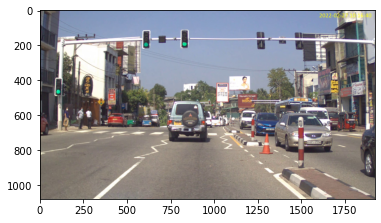

In [14]:
wide_img = cv2.imread('images/wide_t1_018.jpg')
wide_img = cv2.cvtColor(wide_img, cv2.COLOR_BGR2RGB)
plt.imshow(wide_img)
plt.show()

narrow_img = cv2.imread('images/narrow_t1_018.jpg')
narrow_img = cv2.cvtColor(narrow_img, cv2.COLOR_BGR2RGB)
plt.imshow(narrow_img)
plt.show()


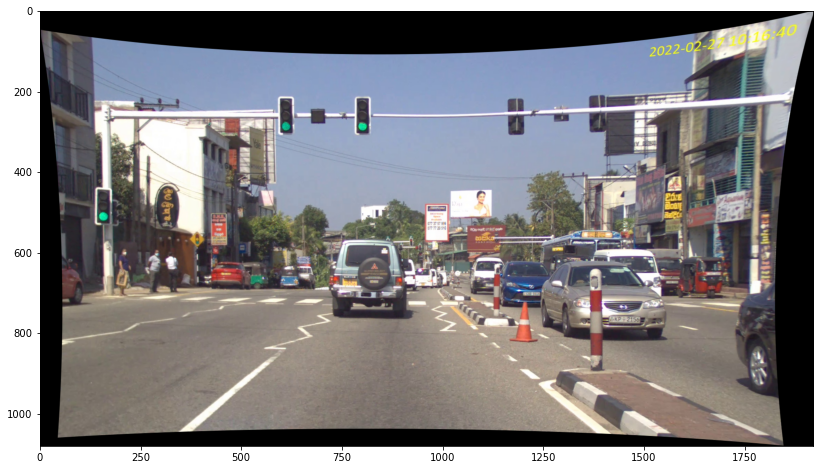

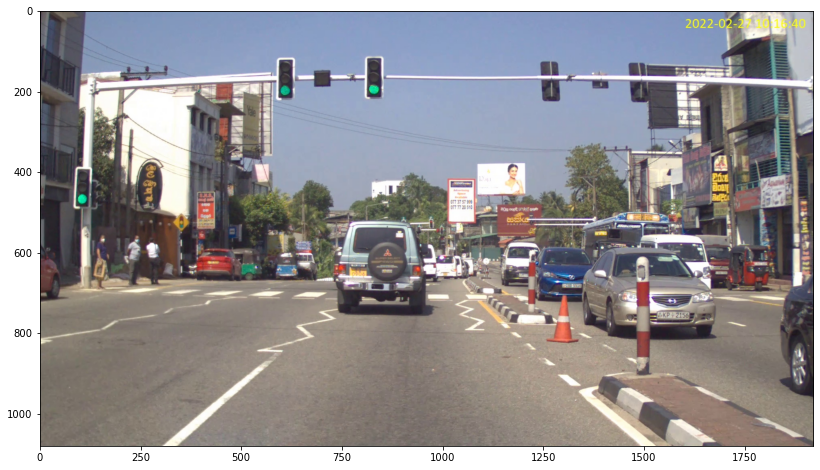

In [15]:
narrow_img_undist = cv2.undistort(narrow_img, camera_mtx_narrow, dist_coff_narrow, None, newcameramtx_narrow)
plt.figure(figsize = (20,8))
plt.imshow(narrow_img_undist)
plt.show()

plt.figure(figsize = (20,8))
plt.imshow(narrow_img)

(1080, 1920)


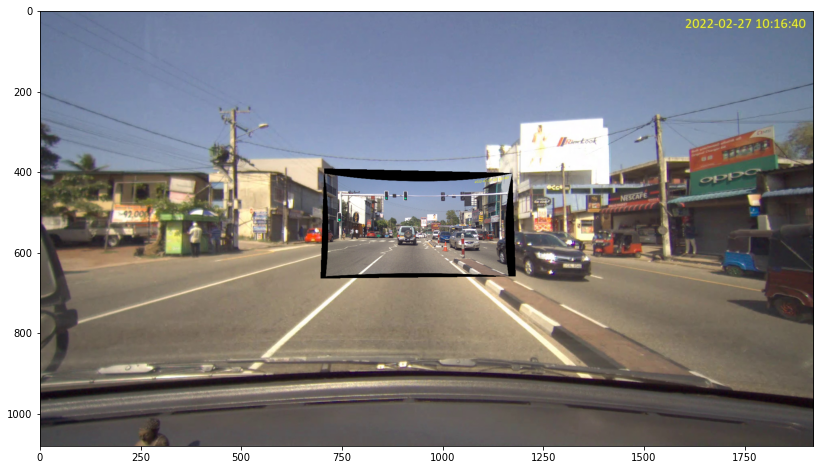

(<matplotlib.image.AxesImage at 0x1321e25d5b0>, None)

In [17]:
# M = np.loadtxt('homography_matrix.txt', usecols=range(3))

pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,homography_mtx)

warped_narrow_img = cv2.warpPerspective(narrow_img_undist, homography_mtx, (w, h)) #wraped image

# plt.imshow(dst, 'gray'),plt.show()
dst_2 = np.squeeze(dst)
mask = np.zeros(wide_img.shape[0:2])
print(mask.shape)
cv2.fillPoly(mask,np.int32([dst_2]),1)
poly_copied = cv2.bitwise_and(warped_narrow_img,warped_narrow_img,mask = np.uint8(mask))
# plt.imshow(poly_copied, ),plt.show()

mask_inverse = np.ones(narrow_img_undist.shape[0:2])
#assuming src1 and src2 are of same size
cv2.fillPoly(mask_inverse,np.int32([dst_2]),0)
img1_middle_removed = cv2.bitwise_and(wide_img,wide_img,mask = np.uint8(mask_inverse))

concatted_img = np.add(poly_copied,img1_middle_removed)
plt.figure(figsize = (20,8))
plt.imshow(concatted_img,),plt.show()
# cv2.imwrite("stitched_img.png",cv.cvtColor(concatted_img,cv.COLOR_RGB2BGR))

In [1]:
np.savetxt('homography_matrix.txt',homography_mtx)